# Peer-graded Assignment: Эксперименты с моделью

На прошлой неделе вы поучаствовали в соревновании на kaggle и, наверняка, большинство успешно справилось с прохождением baseline, а значит пора двигаться дальше - заняться оптимизацией модели, провести серию экспериментов и построить сильное финальное решения.

В этом задании вам нужно провести ряд эскпериментов, оценить качество полученных в процессе экспериментирования моделей и выбрать лучшее решение. 

Задание будет оцениваться на основании загруженного jupyther notebook и развернутых ответов на поставленные вопросы.

In [146]:
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn import preprocessing, manifold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import average_precision_score, roc_auc_score
import xgboost as xgb
import lightgbm as lgb
from scipy.stats import ttest_rel
import statsmodels
import statsmodels.api as sm
from sklearn import ensemble, linear_model,model_selection, metrics
from sklearn.model_selection import KFold, cross_val_score
from sklearn.svm import LinearSVC

import warnings
warnings.filterwarnings('ignore')
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
def get_data():
    X = pd.read_csv('orange_small_churn_data.txt')
    Y = pd.read_csv('orange_small_churn_labels.txt',header=None)
    Y.rename(columns={0: 'label'},inplace=True)
    churn_test = pd.read_csv('orange_small_churn_test_data.csv').drop(['ID'],axis = 1)
    return (X,Y,churn_test)

In [3]:
def labelEncoder(data):
    data.apply(str)
    le = preprocessing.LabelEncoder()
    for m in range(data.shape[1]):
        le.fit(data.iloc[:,m])
        data.iloc[:,m] = le.transform(data.iloc[:,m])        
    return data

In [4]:
def prepare_data(data):
    num = data.iloc[:, 1:191]
    cat = data.iloc[:, 191:]
    num.dropna(axis=1, thresh=num.shape[0]*0.05, subset=None, inplace=True)
    cat.dropna(axis=1, thresh=num.shape[0]*0.05, subset=None, inplace=True)
    num.fillna(num.mean(),inplace=True)
    cat.fillna('NO', inplace=True)
    data_new = pd.concat([num,labelEncoder(cat)],axis=1)
    return data_new

In [83]:
def prepare_data_zero(data):
    num = data.iloc[:, 1:191]
    cat = data.iloc[:, 191:]
    num.dropna(axis=1, thresh=num.shape[0]*0.05, subset=None, inplace=True)
    cat.dropna(axis=1, thresh=num.shape[0]*0.05, subset=None, inplace=True)
    num.fillna(0,inplace=True)
    cat.fillna('NO', inplace=True)
    data_new = pd.concat([num,labelEncoder(cat)],axis=1)
    return data_new

In [116]:
def prepare_data_cat_top(data):
    num = data.iloc[:, 1:191]
    cat = data.iloc[:, 191:]
    num.dropna(axis=1, thresh=num.shape[0]*0.05, subset=None, inplace=True)
    cat.dropna(axis=1, thresh=num.shape[0]*0.05, subset=None, inplace=True)
    num.fillna(num.mean(),inplace=True)
    for i in range(len(cat.columns.values)):
        cat.fillna(cat.iloc[:,i].value_counts().index[0], inplace=True)
    data_new = pd.concat([num,labelEncoder(cat)],axis=1)
    return data_new

In [5]:
def result(estimator, X, Y):
    score = ['roc_auc', 'precision', 'recall', 'f1_weighted']
    skf = model_selection.StratifiedKFold(n_splits=5, shuffle=True)
    for i in score:
        res = model_selection.cross_val_score(estimator, X, Y, scoring=i, cv = skf)
        print("Scores for metric %s:" % i)
        print(res)
        print(res.mean())
    print('==============================================')

In [40]:
def undersampling_X (X, y, ratio):
    data = pd.concat([X,y],axis=1)
    Churn = data[data['label'] == 1]
    NoChurn = data[data['label'] == -1]
    size_churn = len(Churn)
    size_nochurn = len(NoChurn)
    size_for_new_data = np.random.randint(0, size_nochurn , size_churn * ratio)
    new_date = pd.concat([Churn, NoChurn.iloc[size_for_new_data,:]])
    return new_date.iloc[:,:77]

In [41]:
def undersampling_y (X, y, ratio):
    data = pd.concat([X,y],axis=1)
    Churn = data[data['label'] == 1]
    NoChurn = data[data['label'] == -1]
    size_churn = len(Churn)
    size_nochurn = len(NoChurn)
    size_for_new_data = np.random.randint(0, size_nochurn , size_churn * ratio)
    new_date = pd.concat([Churn, NoChurn.iloc[size_for_new_data,:]])
    return new_date.iloc[:,77:]

In [7]:
def data_for_baseline (X,Y):
    X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.1, random_state=123)
    return X_train, X_test, y_train, y_test 

In [93]:
X,y,_ = get_data()

In [78]:
X = prepare_data(X)

## Инструкции

1\. Начнем с простого. Давайте оценим как много объектов действительно нужно для построения качественной модели. Для обучения доступна достаточно большая выборка и может так оказаться, что начиная с некоторого момента рост размера обучающей выборки перестает влиять на качество модели. Постройте кривые обучения, обучая модель на выборках разного размера начиная с небольшого количество объектов в обучающей выборке и постепенно наращивая её размер с некоторым шагом. Обратите внимание на `sklearn.model_selection.learning_curve`

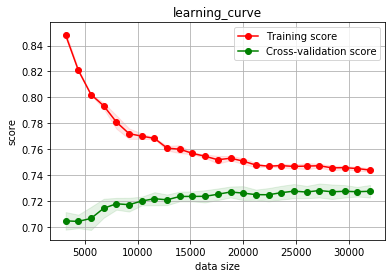

In [45]:
def plot_learning_curve(estimator, X, y):
    plt.figure()
    plt.title("learning_curve")
    plt.xlabel("data size")
    plt.ylabel("score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=5, train_sizes=np.linspace(0.1, 1, 25), 
                                                                scoring='roc_auc')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, 
                     color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

estimator = xgb.XGBClassifier(n_estimators = 30, max_depth=3)
plot_learning_curve(estimator, X, y)

**буду юзать все выборку, т.к. кач-во на cv растет**

2\. Часто несбалансированные по классам выборки приводят к различным проблемам при обучении моделей. Давайте попробуем по-разному обработать выборку, поиграть с распределением объектов по классам и сделать выводы о том, как соотношение классов влияет на качество модели.

2.1\. Задайте веса объектам так, чтобы соотношение классов с учетом весов объектов изменилось. Попробуйте не менее трёх различных вариантов весов. Меняются ли результаты классификации? Как это сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

**понятно что баланс почти не влияет на roc auc. посмотрим на другие метрики и найдем баланс. Будем увеличивать вес для класса 1 - отток с 1 до 16 с шагом 5**


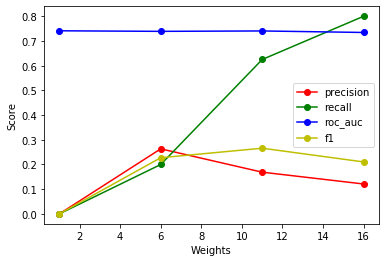

In [67]:
X_train, X_test, y_train, y_test = data_for_baseline(X,y)
weights = [1,6,11,16]
precision, recall, roc_auc, f1 = [], [], [], []
for i in weights:
    weight_list = list(map(lambda x: i if x == 1 else 1, y_train.values))
    estimator.fit(X_train, y_train, sample_weight = weight_list)
    predict = estimator.predict(X_test)
    score = estimator.predict_proba(X_test)[:,1]
    precision.append(metrics.precision_score(y_test, predict))
    recall.append(metrics.recall_score(y_test,predict))
    roc_auc.append(metrics.roc_auc_score(y_test, score))
    f1.append(metrics.f1_score(y_test, predict))

plt.figure()
plt.xlabel("Weights")
plt.ylabel("Score")
plt.plot(weights, precision, 'o-', color="r", label = "precision")
plt.plot(weights, recall, 'o-', color="g", label = "recall")
plt.plot(weights, roc_auc, 'o-', color="b", label = "roc_auc")
plt.plot(weights, f1, 'o-', color="y", label = "f1")
plt.legend(loc="best")
plt.show()

**как видим , увеличение веса класса отток (-1) до 11 дает лучший скор** 

2.2\. Примените к выборке технологию undersampling: для этого нужно убрать из обучения некоторое количество объектов большего класса таким образом, чтобы соотношение классов изменилось. Попробуйте не менее трёх различных вариантов undersampling (варианты могут отличаться как по количество отфильтрованных объектов, так и по принципу выборка объектов для отсеивания из выборки). Меняются ли результаты классификации? Как это сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

In [46]:
estimator = xgb.XGBClassifier(n_estimators = 30, max_depth=3)

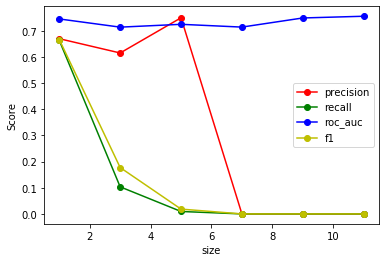

In [82]:
precision, recall, roc_auc, f1 = [], [], [], []
ratio = [1,3,5,7,9,11]
for i in size:
    data = undersampling_X(X,y,i)
    label = undersampling_y(X,y,i)
    X_train, X_test, y_train, y_test = data_for_baseline(data,label)
    estimator.fit(X_train, y_train)
    predict = estimator.predict(X_test)
    score = estimator.predict_proba(X_test)[:,1]
    precision.append(metrics.precision_score(y_test, predict))
    recall.append(metrics.recall_score(y_test,predict))
    roc_auc.append(metrics.roc_auc_score(y_test, score))
    f1.append(metrics.f1_score(y_test, predict))

plt.figure()
plt.xlabel("size")
plt.ylabel("Score")
plt.plot(ratio, precision, 'o-', color="r", label = "precision")
plt.plot(ratio, recall, 'o-', color="g", label = "recall")
plt.plot(ratio, roc_auc, 'o-', color="b", label = "roc_auc")
plt.plot(ratio, f1, 'o-', color="y", label = "f1")
plt.legend(loc="best")
plt.show()

**видно что рок аук ведет себя отлично, у других ж метрик скор пояти обнуляется при увеличении соотношения классов - напомни , что первоначальное соотношение примерно 1 к 13. Думаю лучше юзать первую модель 2.1**

3\. Теперь перейдем к работе с признаками. Ранее вы реализовали несколько стратегий для обработки пропущенных значений. Сравните эти стратегии между собой с помощью оценки качества моделей кросс-валидации, построенных на датасетах с использованием различных стратегий. Как обработка пропущенных значений сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

In [92]:
X,y,_ = get_data()
X = prepare_data(X)
skf = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=122)

res = model_selection.cross_val_score(estimator, X, y, scoring='roc_auc', cv = skf)
print(res)
print(res.mean())

print('==============================================')


X,y,_ = get_data()
X = prepare_data_zero(X)
res = model_selection.cross_val_score(estimator, X, y, scoring='roc_auc', cv = skf)
print(res)
print(res.mean())

[0.72367569 0.72097186 0.73500962 0.71709849 0.73507133]
0.7263653969584494
[0.72476501 0.71840194 0.73775691 0.71663083 0.7296949 ]
0.7254499177773104


**средними лучше, хоть и не сильно**

4\. Также вы уже реализовали несколько стратегий для обработки категориальных признаков. Сравните эти стратегии между собой с помощью оценки качества моделей по кросс-валидации, построенных на датасетах с использованием различных стратегий. Как обработка категориальных признаков сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

In [117]:
X,y,_ = get_data()
X = prepare_data(X)
skf = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=122)

res = model_selection.cross_val_score(estimator, X, y, scoring='roc_auc', cv = skf)
print(res)
print(res.mean())

print('==============================================')


X,y,_ = get_data()
X = prepare_data_cat_top(X)
res = model_selection.cross_val_score(estimator, X, y, scoring='roc_auc', cv = skf)
print(res)
print(res.mean())

[0.72367569 0.72097186 0.73500962 0.71709849 0.73507133]
0.7263653969584494
[0.72309228 0.72097186 0.73496377 0.7173191  0.73529069]
0.7263275395652369


**one hot использовать не стал в силу большого кол-ва значений. label и замена топом показали пркатически одинаковые рез-ты**

5\. Все ли признаки оказались полезными для построения моделей? Проведите процедуру отбора признаков, попробуйте разные варианты отбора (обратите внимание на модуль `sklearn.feature_selection`). Например, можно выбрасывать случайные признаки или строить отбор на основе l1-регуляризации - отфильтровать из обучения признаки, которые получат нулевой вес при построении регрессии с l1-регуляризацией (`sklearn.linear_model.Lasso`). И всегда можно придумать что-то своё=) Попробуйте как минимум 2 различные стратегии, сравните результаты. Помог ли отбор признаков улучшить качество модели? Поясните свой ответ.

In [122]:
X,y,_ = get_data()
X = prepare_data(X)
l1 = Lasso(alpha = 0.01).fit(X, y)
model = SelectFromModel(l1, prefit=True)
X_new = model.transform(X)
print (X_new.shape)

res = model_selection.cross_val_score(estimator, X_new, y, scoring='roc_auc', cv = skf)
print(res)
print(res.mean())
print('==============================================')


lsvc = LinearSVC(C = 0.25, penalty = "l1", dual=False).fit(X, y)
model = SelectFromModel(lsvc, prefit=True)
X_new = model.transform(X)
print(X_new.shape)
res = model_selection.cross_val_score(estimator, X_new, y, scoring='roc_auc', cv = skf)
print(res)
print(res.mean())


(40000, 26)
[0.72418239 0.72566413 0.7340617  0.71966114 0.73263194]
0.7272402593807155
(40000, 49)
[0.72242727 0.71914514 0.73356022 0.71683464 0.73475679]
0.7253448120349021


**да немного помогло. при этом сильно уменьшился датасет**

6\. Подберите оптимальные параметры модели. Обратите внимание, что в зависимости от того, как вы обработали исходные данные, сделали ли балансировку классов, сколько объектов оставили в обучающей выборке и др. оптимальные значения параметров могут меняться. Возьмите наилучшее из ваших решений на текущий момент и проведите процедуру подбора параметров модели (обратите внимание на `sklearn.model_selection.GridSearchCV`) Как подбор параметров повлиял на качество модели?

In [124]:
X,y,_ = get_data()
X = prepare_data(X)
l1 = Lasso(alpha = 0.01).fit(X, y)
model = SelectFromModel(l1, prefit=True)
X_new = model.transform(X)
estimator = xgb.XGBClassifier(sample_weight = 11)
params = {'max_depth': [3, 4], 'n_estimators': [20, 40, 60]}
clf = GridSearchCV(estimator, params, cv = 2)
clf.fit(X_new, y)
print(clf.best_estimator_)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=60, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, sample_weight=11, scale_pos_weight=1,
              seed=None, silent=None, subsample=1, verbosity=1)


In [125]:
res = model_selection.cross_val_score(clf, X_new, y, scoring='roc_auc', cv = skf)
print(res)
print(res.mean())

[0.72874165 0.72876151 0.73635155 0.72367739 0.73613404]
0.7307332276439414


**классификатор улучшился. НО, при бустинге большое число дереверьев ведет к переобуччению, а увеличение глубины к потери кач-ва. При этом испольщование грид серча может натолкнуться на выбросы и сбайнуть. Поэтому следует пройтись используя стат значимость** 

In [127]:
X,y,_ = get_data()
X = prepare_data(X)
l1 = Lasso(alpha = 0.01).fit(X, y)
model = SelectFromModel(l1, prefit=True)
X_new = model.transform(X)
x_short, X_test, y_short, y_test = data_for_baseline(X_new,y)

**далее чтобы избежать проблем с выбросами, которые повлияют на усреднение метрики. мы для каждого фолда будем проверть кач-ва двух аглорритмов. максимизируя рок аук мы найдем максимальную разницу средних / макс. т статистику. тем самым по итогу определим оптимальное число гипперпараметра.**

In [130]:
scores_30_trees = np.array([])
scores_40_trees = np.array([])
for i in range(10):
    fold = KFold(n_splits=5, shuffle=True, random_state=i)
    scores_30_trees_on_this_split = cross_val_score(
                                             estimator=xgb.XGBClassifier(n_estimators=30, sample_weight = 11),
                                             X=x_short, y=y_short,
                                             cv=fold, scoring='roc_auc')
    scores_30_trees = np.append(scores_30_trees,
                                 scores_30_trees_on_this_split)
    scores_40_trees_on_this_split = cross_val_score(
                                            estimator=xgb.XGBClassifier(n_estimators=40, sample_weight = 11),
                                            X=x_short, y=y_short,
                                            cv=fold, scoring='roc_auc')
    scores_40_trees = np.append(scores_40_trees,
                                 scores_40_trees_on_this_split)
ttest_rel(scores_30_trees, scores_40_trees)

Ttest_relResult(statistic=-9.99794501031107, pvalue=2.0269442955633144e-13)

40 лучше чем 30. построим график и выберем среднее. это лучше гридсерсча , так как он выбирает единтсвенное лучше число методом перебора. а как мы знаем при множестве экспериментов нужна поправка на мно-ть. в грид серче ее нет, и он мож выброс выцепить

Populating the interactive namespace from numpy and matplotlib


Text(0, 0.5, 't-statistic')

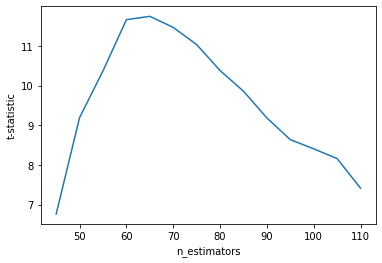

In [131]:
%pylab inline
t_stats = []
n_trees = []
for j in range(45, 115, 5):
    current_score = np.array([])
    for i in range(10):
        fold = KFold(n_splits=5, shuffle=True, random_state=i)
        scores_on_this_split = cross_val_score(
                                      estimator=xgb.XGBClassifier(n_estimators=j, sample_weight = 11),
                                      X=x_short, y=y_short,
                                      cv=fold, scoring='roc_auc')
        current_score = np.append(current_score,
                                  scores_on_this_split)
    t_stat, p_value = ttest_rel(current_score, scores_40_trees)
    t_stats.append(t_stat)
    n_trees.append(j)
plt.plot(n_trees, t_stats)
plt.xlabel('n_estimators')
plt.ylabel('t-statistic')

**65 -  подходящее число деревьев**

7\. Предложите методику оценки того, какие признаки внесли наибольший вклад в модель (например, это могут быть веса в случае регрессии, а также большое количество моделей реализуют метод `feature_importances_` - оценка важности признаков). На основе предложенной методики проанализируйте, какие признаки внесли больший вклад в модель, а какие меньший?

отсюда https://stackoverflow.com/questions/37627923/how-to-get-feature-importance-in-xgboost 

In [135]:
X,y,_ = get_data()
X = prepare_data(X) # mean()/label encoding
l1 = Lasso(alpha = 0.01).fit(X, y)
model = SelectFromModel(l1, prefit=True) # отбор через l1
X_new = model.transform(X)
estimator=xgb.XGBClassifier(n_estimators=65, max_depth = 4,  sample_weight = 11)
estimator.fit(X_new,y)
features = estimator.get_booster().get_score(importance_type="gain")

In [140]:
import operator

In [145]:
sorted(features.items(), key=operator.itemgetter(1), reverse=True)

[('f13', 34.03771227032075),
 ('f7', 28.63739594194445),
 ('f24', 17.033200742691484),
 ('f6', 16.097886194402083),
 ('f20', 14.210877067264704),
 ('f22', 13.970566536363636),
 ('f15', 13.152068261589475),
 ('f23', 9.477244815517242),
 ('f5', 7.2950861756875),
 ('f1', 6.878002468400001),
 ('f0', 6.46281052),
 ('f2', 6.39252007),
 ('f3', 6.309710451333333),
 ('f18', 6.127223355769231),
 ('f10', 5.69627926923077),
 ('f12', 5.603996067736843),
 ('f21', 5.59671454456),
 ('f25', 5.44671148137931),
 ('f4', 5.205968592969642),
 ('f8', 5.12612654775),
 ('f19', 5.004801586589745),
 ('f9', 4.779044086615384),
 ('f17', 4.68624568375),
 ('f16', 4.510621144999999),
 ('f11', 4.296226363684211),
 ('f14', 3.6959098337999996)]

8\. Напоследок давайте посмотрим на объекты. На каких объектах достигается наибольшая ошибка классификации? Есть ли межу этими объектами что-то общее? Видны ли какие-либо закономерности? Предположите, почему наибольшая ошибка достигается именно на этих объектах. В данном случае "наибольшую" ошибку можно понимать как отнесение объекта с чужому классу с большой долей уверенности (с высокой вероятностью).

Алгоритм будет ошибаться на выбросах. воспользуюсь tsne

In [ ]:
tsne = manifold.TSNE(n_components = 2, init = 'pca', random_state = 122)
data_2d_tsne = tsne.fit_transform(X_new)

In [ ]:
pylab.figure(figsize = (10, 6))
pylab.scatter(data_2d_tsne[:, 0], data_2d_tsne[:, 1], c = y.values)

**ноутбук не тянет) уже минут 30 считает  - вобщем слудет посмотреть по графику. есть еше вариант воспольщоваться стат модулем OLS и холмом. но для этого мой ноут точно не подойдет**

Так же требуется определить порог для ошибок первого и второго родов. Следует понять , что для данного классифатора важнее( спойлер - recall важнее - тоесть ошибка первого рода менее стращна чем второго)

9\. По итогам проведенных экспериментов постройте финальную решение - модель с наилучшим качеством. Укажите, какие преобразования данных, параметры и пр. вы выбрали для построения финальной модели.

In [ ]:
X,y,_ = get_data()
X = prepare_data(X) # mean()/label encoding

l1 = Lasso(alpha = 0.01).fit(X, y)
model = SelectFromModel(l1, prefit=True) # отбор через l1
X_new = model.transform(X)
X_train, X_test, y_train, y_test = data_for_baseline(X_new,y)
estimator=xgb.XGBClassifier(n_estimators=65, max_depth = 4,  sample_weight = 11)

10\. Подумайте, можно ли еще улучшить модель? Что для этого можно сделать? 

1. найти и удалить выбросы
2. подобрать параметры, через стат значимость
3. нагенерить новые признаки / больше информации о текущих может помочь